<a href="https://colab.research.google.com/github/mezkymy/global-salaries/blob/main/global-salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Salaries
source: https://ai-jobs.net/salaries/download/


## Data Description (from source)



> "We collect salary information anonymously from professionals and employers all over the world and make it publicly available for anyone to use, share and play around with.
> Our goal is to have open salary data for everyone. So newbies, experienced pros, hiring managers, recruiters and also startup founders or people wanting to switch careers can make better decisions."


In [1]:
# ignore FutureWarnings (for bioinfokit)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for tukey
!pip install bioinfokit
from bioinfokit.analys import stat

In [2]:
# load data
account = 'mezkymy'
repo = 'global-salaries'
branch = 'main'
data_file_name = 'salaries.csv'

url = str(f'https://raw.githubusercontent.com/{account}/{repo}/{branch}/{data_file_name}')

raw_data = pd.read_csv(url)
df = raw_data.copy()
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M


# Preliminary Data Exploration

In [3]:
# basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           8805 non-null   int64 
 1   experience_level    8805 non-null   object
 2   employment_type     8805 non-null   object
 3   job_title           8805 non-null   object
 4   salary              8805 non-null   int64 
 5   salary_currency     8805 non-null   object
 6   salary_in_usd       8805 non-null   int64 
 7   employee_residence  8805 non-null   object
 8   remote_ratio        8805 non-null   int64 
 9   company_location    8805 non-null   object
 10  company_size        8805 non-null   object
dtypes: int64(4), object(7)
memory usage: 756.8+ KB


In [4]:
# check values distribution on numerical data
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,8805.000000,8.805000e+03,8805.000000,8805.000000
mean,2022.737422,1.747287e+05,149488.265645,38.693924
std,0.542484,4.560690e+05,64222.105058,48.068060
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.055000e+05,105000.000000,0.000000
50%,2023.000000,1.441000e+05,142200.000000,0.000000
75%,2023.000000,1.900000e+05,185900.000000,100.000000
max,2023.000000,3.040000e+07,615201.000000,100.000000


## Remote Ratio

In [5]:
df.remote_ratio.unique()

array([  0, 100,  50])

Based on the data source and also by checking the data directly, we can see that `remote_ratio` only have three unique values: 0, 50, and 100. This data can be treated as categorical rather than numerical. 0 means up to 20% remote work, while 100 means more than 80% remote work. To avoid confusion with this numerical category, a new feature is created to categorize jobs as onsite, hybrid, and remote, based on its remote ratio.

In [6]:
cond = [df.remote_ratio < 50, df.remote_ratio > 50]
val = ['onsite', 'remote']

df['remote_cat'] = np.select(cond, val, 'hybrid')
pd.value_counts(df.remote_cat)

onsite    5289
remote    3298
hybrid     218
Name: remote_cat, dtype: int64

## Experience Level, Employment Type, and Company Size

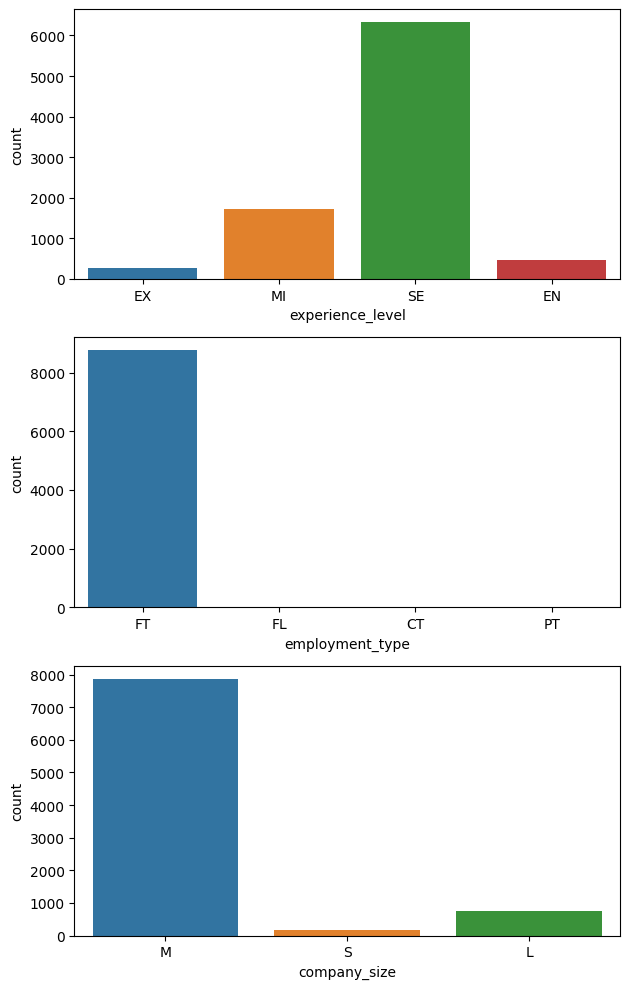

In [7]:
# show count plot based on experience level, employment type, and company size
columns = df.columns
cat = [columns[1], columns[2], columns[10]]
i = 0

fig, axes = plt.subplots(len(cat))

for col in cat:
    sns.countplot(df, ax=axes[i], x=col)
    i += 1

fig.set_figheight(10)
fig.tight_layout()
plt.show()

In [8]:
df.employment_type.value_counts()

FT    8762
CT      18
PT      13
FL      12
Name: employment_type, dtype: int64

Based on employment type, almost all jobs in this dataset are categorized as full-time (FT); while contract, part-time, and full-time jobs only occurs less than 20 times each. The overwhelming discrepancy and the lacking amount of data samples on the three minority categories should be considered when analyzing this dataset. To simplify analysis and also to avoid biases, **only full-time jobs will be analyzed further**.

Based on experience level and company size, there is one category on both variables that is significantly larger in their number of samples than the rest of categories, but other categories still have a decent amount of samples.

In [9]:
# filter dataset to only contain full time employees
df2 = df[df['employment_type'] == 'FT']

## Job Salaries

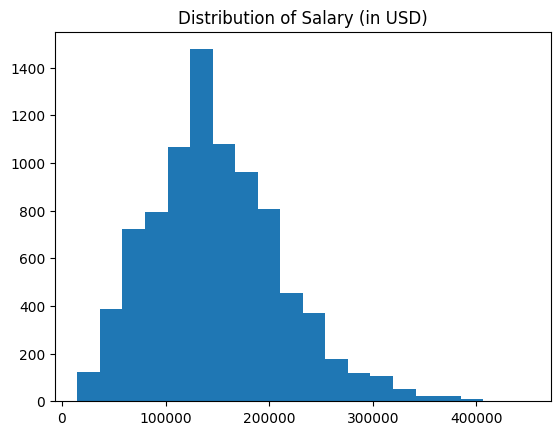

In [10]:
# salary distribution
plt.hist(df2.salary_in_usd, bins=20)

plt.title('Distribution of Salary (in USD)')
plt.show()

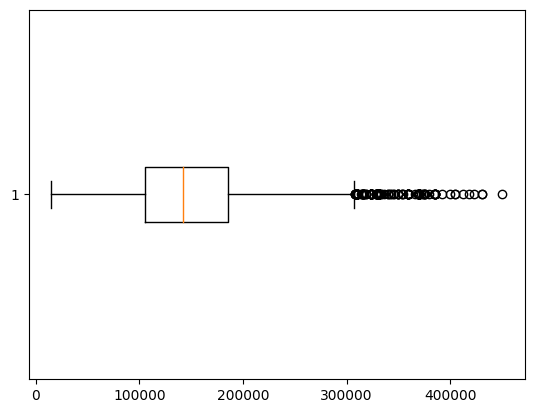

In [11]:
plt.boxplot(df2.salary_in_usd, vert=False)
plt.show()

Based on the distribution, most salaries in the dataset falls between 100K to 200K USD, while there are only a small amount of outliers with salaries above 300K. This is range of salaries combined from all job titles and experience levels. A more detailed analysis on salaries based on job titles and experience levels can be seen further down below.

## Job Titles

In [12]:
# count the number of unique job titles
print('Job Titles:', df2.job_title.unique())
print('\n Number of Unique Job Titles:', df2.job_title.nunique())

Job Titles: ['Data Science Director' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Specialist' 'Data Scientist'
 'ML Engineer' 'Data Engineer' 'Data Analyst' 'Data Architect'
 'Data Product Manager' 'Analytics Engineer' 'BI Data Analyst'
 'Research Scientist' 'Data Integration Engineer' 'AI Engineer'
 'Applied Scientist' 'Machine Learning Scientist' 'BI Developer'
 'Business Intelligence Manager' 'Data Integration Specialist'
 'Data Science Practitioner' 'Research Engineer'
 'Business Intelligence Analyst' 'Business Intelligence Developer'
 'AI Research Engineer' 'Data Science Consultant' 'Data Lead'
 'Head of Data' 'Data Management Specialist' 'AI Developer' 'Data Manager'
 'AI Architect' 'MLOps Engineer' 'Data Science Manager' 'Data Strategist'
 'Business Intelligence Specialist'
 'Machine Learning Infrastructure Engineer' 'Research Analyst'
 'Data Quality Engineer' 'Director of Data Science'
 'Business Data Analyst' 'Data Quality Analyst' 'AI Programmer'
 'Deci

We should take note that some job titles are actually similar, if not completely the same title, as another. For example, ML Engineer is basically the same as Machine Learning Engineer, while BI Analyst is also the same as Business Intelligence Analyst. To simplify things, we shall combine similar job titles as one. Note that there are some ambigous titles such as 'Data Science Engineer' which is quite unclear if it should be categorized into data scientist or data engineer, and such titles will be categorized based on personal understanding of it. Manager, lead, and other hierarchial titles shall be treated the same as basic level, as seniority level shall be represented by experience level instead.

In [13]:
data_analysis_titles = ['Data Analyst', 'Financial Data Analyst', 'Data Analytics Manager', 'Insight Analyst', 'Data Operations Analyst', 'Data Analytics Lead', 'Analytics Engineer',
                        'Finance Data Analyst', 'Compliance Data Analyst', 'Staff Data Analyst', 'Data Visualization Analyst', 'Product Data Analyst', 'Lead Data Analyst',
                        'Data Analytics Specialist', 'Marketing Data Analyst', 'Data Analytics Engineer', 'Data Analytics Consultant', 'Principal Data Analyst',
                        'Data Visualization Specialist', 'Data Visualization Engineer', 'Power BI Developer']

data_science_titles = ['Data Science Director', 'Data Scientist', 'Data Science Practitioner', 'Data Science Consultant', 'Data Science Manager', 'Director of Data Science',
                       'Data Science Engineer', 'Principal Data Scientist', 'Applied Data Scientist', 'Data Science Lead', 'Lead Data Scientist', 'Head of Data Science',
                       'Staff Data Scientist', 'Managing Director Data Science', 'Data Science Tech Lead', 'Data Scientist Lead']

data_engineering_titles = ['Data Engineer', 'Data Architect', 'Azure Data Engineer', 'Data Operations Engineer', 'Data Infrastructure Engineer', 'Data Quality Engineer',
                           'Data Quality Analyst','Principal Data Engineer', 'Software Data Engineer', 'Cloud Data Engineer', 'AWS Data Architect', 'ETL Engineer',
                           'Cloud Database Engineer', 'Big Data Engineer', 'Marketing Data Engineer', 'Big Data Architect', 'Principal Data Architect', 'Cloud Data Architect',
                           'Lead Data Engineer','Data DevOps Engineer', 'Data Modeler', 'Data Modeller', 'ETL Developer']

data_operations_management_titles = ['Data Specialist', 'Data Product Manager', 'Data Integration Engineer', 'Data Integration Specialist', 'Data Lead', 'Head of Data',
                                     'Data Management Specialist', 'Data Manager', 'Data Strategist', 'Data Strategy Manager', 'Data Operations Manager', 'Data Operations Specialist',
                                     'Manager Data Management', 'Analytics Engineering Manager']

business_intelligence_analysis_titles = ['Business Intelligence Engineer', 'BI Data Analyst', 'BI Developer', 'Business Intelligence Analyst', 'Business Intelligence Manager',
                                         'Business Intelligence Developer', 'Business Data Analyst', 'Business Intelligence Specialist', 'BI Analyst', 'Head of Machine Learning',
                                         'Business Intelligence Data Analyst', 'BI Data Engineer']

machine_learning_titles = ['Machine Learning Engineer', 'ML Engineer', 'Machine Learning Scientist', 'MLOps Engineer', 'Machine Learning Infrastructure Engineer',
                           'Machine Learning Researcher', 'Machine Learning Software Engineer', 'Machine Learning Operations Engineer', 'Machine Learning Manager',
                           'Principal Machine Learning Engineer', 'Staff Machine Learning Engineer', 'Machine Learning Specialist', 'Deep Learning Engineer',
                           'Lead Machine Learning Engineer', 'Machine Learning Research Engineer', 'NLP Engineer', 'Applied Machine Learning Scientist',
                           'Applied Machine Learning Engineer', 'Deep Learning Researcher', 'Machine Learning Developer']

AI_titles = ['AI Engineer', 'AI Research Engineer', 'AI Developer', 'AI Architect', 'AI Programmer', 'AI Scientist', 'Computer Vision Engineer', 'Computer Vision Software Engineer']

research_scientist_titles = ['Research Scientist', 'Applied Scientist', 'Research Engineer', 'Research Analyst']


def grouping(d):
    if d['job_title'] in data_analysis_titles:
        return 'Data Analyst'
    elif d['job_title'] in data_science_titles:
        return 'Data Scientist'
    elif d['job_title'] in data_engineering_titles:
        return 'Data Engineer'
    elif d['job_title'] in data_operations_management_titles:
        return 'Data Operations'
    elif d['job_title'] in business_intelligence_analysis_titles:
        return 'Business Intelligence/Analyst'
    elif d['job_title'] in machine_learning_titles:
        return 'Machine Learning'
    elif d['job_title'] in AI_titles:
        return 'AI Developer/Engineer'
    elif d['job_title'] in research_scientist_titles:
        return 'Research Scientist'
    else:
        return 'Others'


df2['job_title_group'] = df2.apply(grouping, axis=1)

<ipython-input-13-3f8833c85f6e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['job_title_group'] = df2.apply(grouping, axis=1)


In [14]:
df2.job_title_group.value_counts()

Data Engineer                    2388
Data Scientist                   2101
Data Analyst                     1662
Machine Learning                 1195
Research Scientist                666
Business Intelligence/Analyst     317
Data Operations                   269
AI Developer/Engineer             119
Others                             45
Name: job_title_group, dtype: int64

After grouping all the job titles in this dataset, we can see that the most common job title groups are **Data Engineer**, **Data Scientist**, and **Data Analyst**. There are some job titles that are hard to categorize into the other groups and is labeled as 'Others' instead, and only occured less than 50 times combined. These group will not be analyzed further since the number of sample is too small and it is a combination of various jobs that might be very different and not comparable to each other.

In [15]:
# filtered dataframe without 'Others' job title group
df3 = df2.drop(df2[df2['job_title_group'] == 'Others'].index)
df3

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat,job_title_group
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M,onsite,Data Scientist
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M,onsite,Data Scientist
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite,Business Intelligence/Analyst
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite,Business Intelligence/Analyst
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M,onsite,Machine Learning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L,remote,Data Operations
8800,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,remote,Data Scientist
8801,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L,remote,Data Scientist
8802,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S,remote,Data Scientist


After filtering out jobs categorized as 'Others' (and also after filtering out non full-time jobs), we still retain 8717 data entries, which is 99% of the original dataset amount.

## Company Locations

In [16]:
# count the number of unique company locations
print('Company Locations:', df3.company_location.unique())
print('\n Number of Unique Company Locations:', df3.company_location.nunique())

Company Locations: ['US' 'GB' 'CA' 'NL' 'LT' 'PT' 'GI' 'AU' 'FR' 'CO' 'UA' 'SI' 'IN' 'RO'
 'ES' 'GR' 'LV' 'MU' 'DE' 'PL' 'RU' 'IT' 'KR' 'EE' 'CZ' 'CH' 'BR' 'QA'
 'KE' 'DK' 'GH' 'SE' 'PH' 'TR' 'AD' 'EC' 'MX' 'IL' 'NG' 'SA' 'NO' 'AR'
 'JP' 'ZA' 'HK' 'CF' 'FI' 'IE' 'SG' 'TH' 'HR' 'AM' 'BA' 'PK' 'HU' 'AT'
 'PR' 'AS' 'BE' 'ID' 'EG' 'AE' 'MY' 'HN' 'IQ' 'CN' 'NZ' 'CL' 'MD' 'LU'
 'MT']

 Number of Unique Company Locations: 71


In [17]:
# list of company locations with more than 50 entries
company_location_count = df3.company_location.value_counts()
company_location_count[company_location_count.values > 50]

US    7513
GB     421
CA     203
ES     108
DE      70
Name: company_location, dtype: int64

While there are 57 different countries where the data are sourced from, only 5 countries have more than 50 entries each. Since having less than 50 data may result in sampling bias, the analysis will focus only on the 5 countries.

In [18]:
# filtered dataframe containing only the location that occurs more than 50 times
df4 = df3[df3['company_location'].isin(list(company_location_count[company_location_count.values > 50].index))]
df4

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat,job_title_group
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M,onsite,Data Scientist
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M,onsite,Data Scientist
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite,Business Intelligence/Analyst
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite,Business Intelligence/Analyst
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M,onsite,Machine Learning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8797,2021,MI,FT,Applied Machine Learning Scientist,423000,USD,423000,US,50,US,L,hybrid,Machine Learning
8799,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L,remote,Data Operations
8800,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,remote,Data Scientist
8801,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L,remote,Data Scientist


# Remote Ratio to Salary

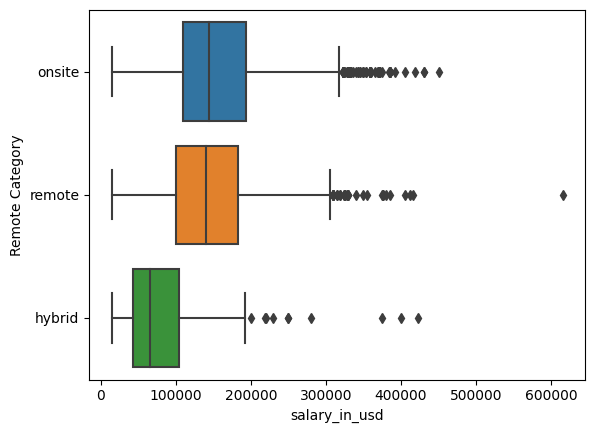

In [19]:
# order remote ratio by median value
group_remote = df4.loc[:,['remote_cat', 'salary_in_usd']] \
    .groupby(['remote_cat']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# boxplot for salary in usd based on experience level
sns.boxplot(data=df, x='salary_in_usd', y='remote_cat', order=group_remote.index).set(ylabel='Remote Category')
plt.show()

While the salary between jobs with onsite or remote does not seem to differ significantly, hybrid jobs seems to earn significantly lower in general.

In [20]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ remote_cat', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
remote_cat,3.149784e+11,2.0,41.563178,1.093967e-18
Residual,3.149543e+13,8312.0,NaN,NaN


In [21]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='remote_cat', anova_model='salary_in_usd ~ remote_cat')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,onsite,remote,7563.833438,4270.990780,10856.676097,7.614961,0.001
1,onsite,hybrid,47724.649515,33365.319057,62083.979972,11.018064,0.001
2,remote,hybrid,40160.816076,25705.807012,54615.825140,9.210451,0.001


Tukey's HSD shows that all three categories differ with each other significantly, although the difference of salaries between onsite and remote jobs are not as large compared to the difference with hybrid jobs.

# Experience Levels per Job Title

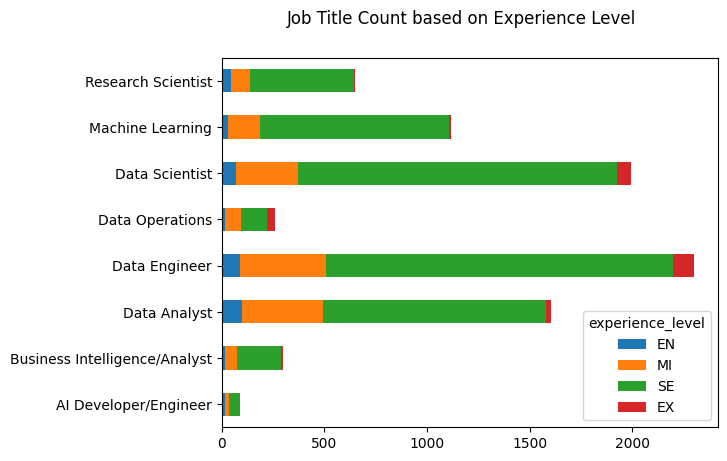

In [22]:
df4.groupby(by=['job_title_group', 'experience_level']).size().unstack().reindex(['EN','MI','SE','EX'], axis=1).plot(kind='barh', stacked=True, ylabel='')
plt.suptitle('Job Title Count based on Experience Level')
plt.show()

In all selected job titles, most respondent are Senior-level, composing more than 50% of all experience level count. Mid-level are also quite common across the board, while entry level are mostly on Data Analyst, Engineer, or Scientist role.

# Salaries per Job Title & Experience Levels

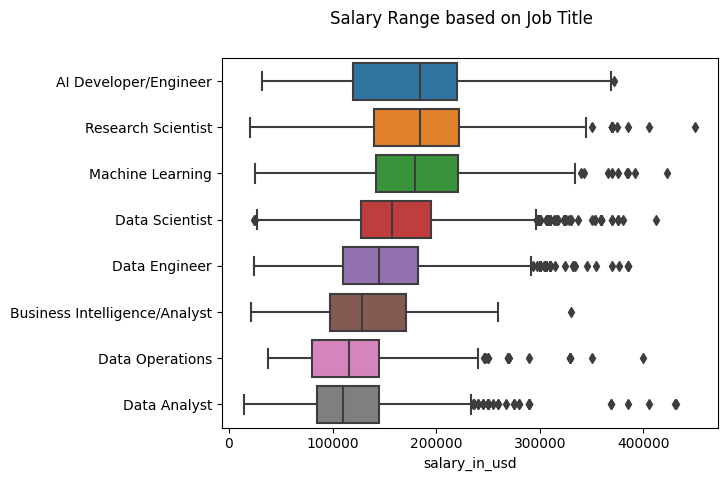

In [23]:
# order titles by median value
grouped = df4.loc[:,['job_title_group', 'salary_in_usd']] \
    .groupby(['job_title_group']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected job titles
sns.boxplot(data=df4, x='salary_in_usd', y='job_title_group', order=grouped.index).set(ylabel=None)
plt.suptitle('Salary Range based on Job Title')
plt.show()

In general, Data Analyst and Data Operations are the lowest paying job title among the selected job titles, with a quite significant portion of respondents on those groups still earns less than 100k. Other job titles mostly earns between 100 to 200k, with titles related to AI/Research/ML earning the most.

In every title, there are some outliers that earns up to 300-400k, which suggests that any of these titles can still earn more than the top titles depending on other factors such as experience level and location. One exception to this is for Business Intelligence/Analyst, where there are only one outlier that earns more than 300k while the rest earns quite significantly under it.

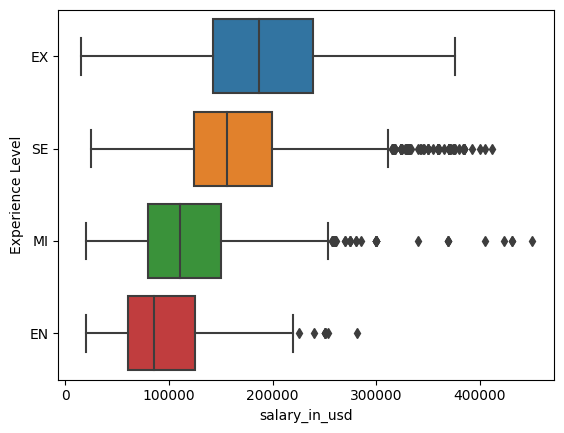

In [24]:
# order experience level by median value
grouped2 = df4.loc[:,['experience_level', 'salary_in_usd']] \
    .groupby(['experience_level']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# boxplot for salary in usd based on experience level
sns.boxplot(data=df4, x='salary_in_usd', y='experience_level', order=grouped2.index).set(ylabel='Experience Level')
plt.show()

In [25]:
grouped2

,salary_in_usd
experience_level,
EX,187200.0
SE,155499.0
MI,110736.0
EN,85000.0


Based on experience level, the median value on lower experience level is less than the higher experience levels, but it is not quite clear-cut on whether the difference is significant or not based only on the graph above - especially since the highest salary among the dataset is earned by a mid-level, and that some executive-level still earns less than the average entry level, even when ignoring the outliers (which is shown by the dots on the graph above).

To check whether or not the difference of experience level is actually significant to salary earned, an analysis of variance (ANOVA) will be performed.

In [26]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ experience_level', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
experience_level,3.828296e+12,3.0,379.015557,9.723321e-231
Residual,2.798211e+13,8311.0,NaN,NaN


In [27]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='experience_level', anova_model='salary_in_usd ~ experience_level')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,EX,MI,70740.647726,60687.052480,80794.242972,25.569255,0.001
1,EX,SE,27844.904145,18352.489064,37337.319227,10.659564,0.001
2,EX,EN,94495.688339,82402.068251,106589.308428,28.393969,0.001
3,MI,SE,42895.743581,38631.336123,47160.151038,36.553245,0.001
4,MI,EN,23755.040613,15133.273177,32376.808050,10.012209,0.001
5,SE,EN,66650.784194,58690.505276,74611.063112,30.426179,0.001


Based on the p-value of ANOVA and the p-value of Tukey's HSD on all group pairs (lower than 0.01), we can conclude that each group of experience level is significantly different in their average salary received. The increase of salary goes in line with the increase in experience level, although some respondents with the lowest experience level (entry-level) still obtained a higher salary than the average salary of the highest experience level (executive-level).

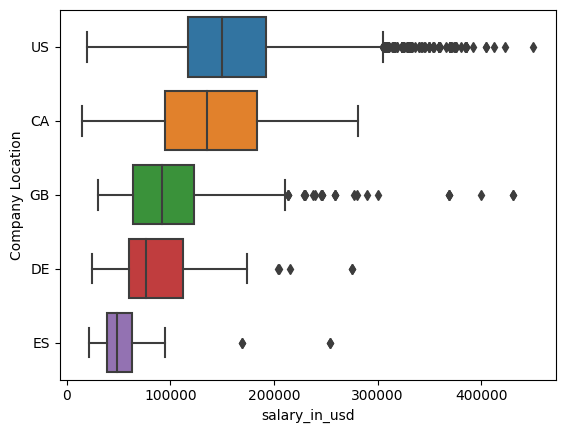

In [28]:
# order locations by median value
grouped3 = df4.loc[:,['company_location', 'salary_in_usd']] \
    .groupby(['company_location']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected company locations
sns.boxplot(data=df4, x='salary_in_usd', y='company_location', order=grouped3.index).set(ylabel='Company Location')
plt.show()

By analyzing the chart above visually, it can be predicted that company location might be even more relevant than the actual job title and experience level. Spain (ES) only have 2 outliers that have a salary of more than 100k with the rest earning less than it, while the majority of Great Britain (GB) and Germany (DE) earns close to 100k. Most US and CA employees earns between 100k to 200k.

In [29]:
# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ company_location', data=df4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
company_location,2.454979e+12,4.0,173.740222,3.781363e-143
Residual,2.935543e+13,8310.0,NaN,NaN


In [30]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df4, res_var='salary_in_usd', xfac_var='company_location', anova_model='salary_in_usd ~ company_location')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,US,GB,52716.617799,44594.998573,60838.237024,25.044968,0.001000
1,US,CA,16625.883891,5091.732045,28160.035736,5.561791,0.001000
2,US,ES,102049.845212,86334.219496,117765.470927,25.055106,0.001000
3,US,DE,66405.963201,46934.029509,85877.896893,13.158718,0.001000
4,GB,CA,36090.733908,22234.426928,49947.040889,10.049947,0.001000
5,GB,ES,49333.227413,31842.044606,66824.410219,10.882682,0.001000
6,GB,DE,13689.345402,-7241.894075,34620.584880,2.523500,0.383892
7,CA,ES,85423.961321,66110.302012,104737.620630,17.065960,0.001000
8,CA,DE,49780.079310,27303.586123,72256.572498,8.545601,0.001000
9,ES,DE,35643.882011,10761.418731,60526.345290,5.527226,0.001000


Based on both ANOVA and Tukey's HSD results, it can be assumed that company location significantly affects salary received, with every group/location differing to each other with an exception of Great Britain and Germany which is quite close to each other and proved to be not significantly different with a p-value of 0.38.

# Salaries Based on Company Location & Job Titles

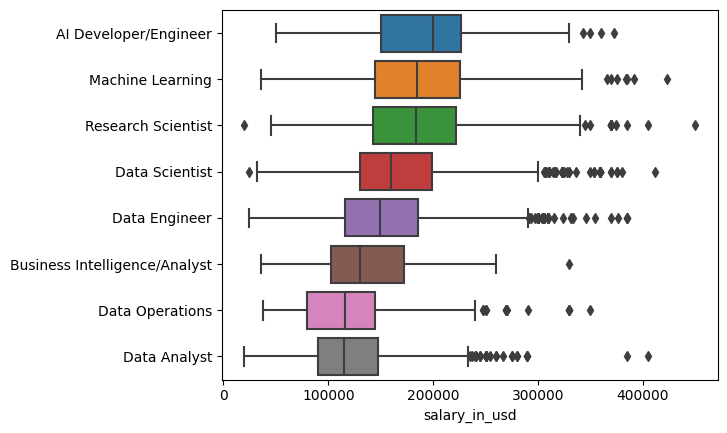

In [31]:
# order titles by median value
df_US = df4[df4['company_location'] == 'US']
grouped_US = df_US.loc[:,['job_title_group', 'salary_in_usd']] \
    .groupby(['job_title_group']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected job titles
sns.boxplot(data=df_US, x='salary_in_usd', y='job_title_group', order=grouped_US.index).set(ylabel=None)
plt.show()

Since the overwhelming majority of the companies in this dataset is located at US, analyzing US seperately shows a similar output as to analyzing the combined/overall data.

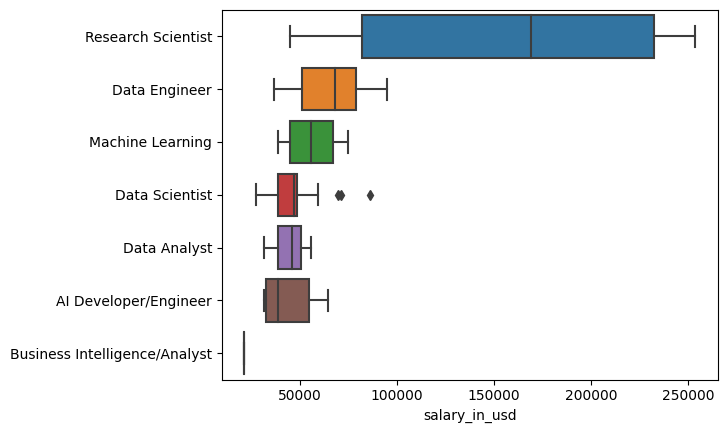

In [45]:
# order titles by median value
df_ES = df4[df4['company_location'] == 'ES']
grouped_ES = df_ES.loc[:,['job_title_group', 'salary_in_usd']] \
    .groupby(['job_title_group']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in Spain for each selected job titles
sns.boxplot(data=df_ES, x='salary_in_usd', y='job_title_group', order=grouped_ES.index).set(ylabel=None)
plt.show()

Meanwhile at Spain, the highest salaries are obtained by Research Scientists, but should also be noted that the number of data from this country is quite limited which is why the range of salary for Research Scientists are so widely varied.

# Yearly Salary Growth

In [33]:
grouped5 = df4.loc[:,['job_title_group', 'salary_in_usd', 'work_year']] \
    .groupby(['job_title_group', 'work_year']) \
    .mean() \

grouped5

salary_in_usd
job_title_group               work_year               
AI Developer/Engineer         2021        73582.000000
                              2022       143846.000000
                              2023       186330.750000
Business Intelligence/Analyst 2020       109333.333333
                              2021        85314.750000
                              2022        91045.727273
                              2023       135725.402135
Data Analyst                  2020        66316.500000
                              2021        96729.160000
                              2022       117411.147147
                              2023       119932.312399
Data Engineer                 2020        99218.416667
                              2021       131898.692308
                              2022       143731.050562
                              2023       152856.623399
Data Operations               2021       200000.000000
                              2022       122858.000000
                              2023       125263.602564
Data Scientist                2020       142028.000000
                              2021       113991.978723
                              2022       146758.023474
                              2023       168866.540613
Machine Learning              2020       163776.000000
                              2021       156879.312500
                              2022       153810.221477
                              2023       190966.674051
Research Scientist            2020       450000.000000
                              2021        95978.600000
                              2022       183099.971429
                              2023       186171.151565

## Data Scientist

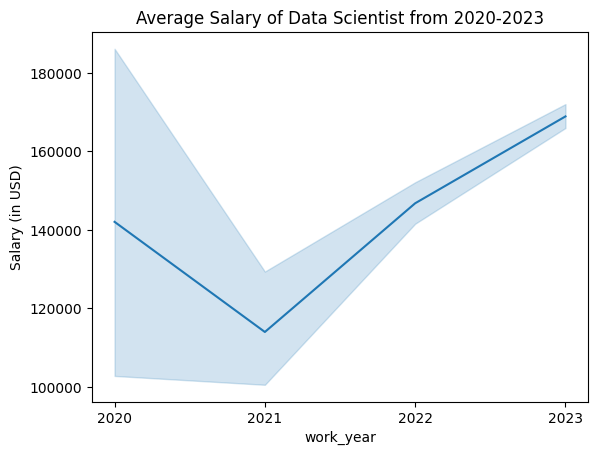

In [34]:
# Overall, using mean with 95% confidence interval
df_ds = df4[df4['job_title_group']=='Data Scientist']
sns.lineplot(data=df_ds, x="work_year", y="salary_in_usd").set(ylabel='Salary (in USD)')
plt.xticks(ticks=range(2020, 2024))
plt.title('Average Salary of Data Scientist from 2020-2023')
plt.show()

Data Scientist salaries across the board are increasing yearly, except at 2021 where it shows a decline from 142k to 114k. From 2020 to 2023, it shows a quite significant growth from 142k to 169k (+27k), which is around 20% increase over 3 years or around 6% annual increase. This increase is similar to the US total inflation from 2020-2023 which is around 19% compounded (source: [usinflationcalculator.com](https://www.usinflationcalculator.com/inflation/current-inflation-rates/))

To further analyze this, we will check if the same increase happens on entry level-only too.

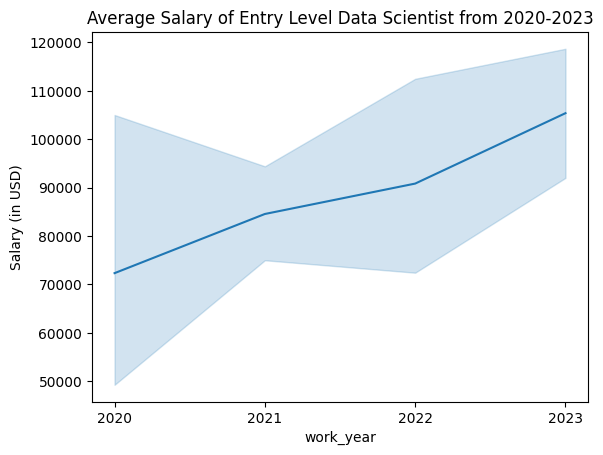

In [35]:
# Entry level-only
df_ds_en = df_ds[df_ds['experience_level']=='EN']
sns.lineplot(data=df_ds_en, x="work_year", y="salary_in_usd").set(ylabel='Salary (in USD)')
plt.xticks(ticks=range(2020, 2024))
plt.title('Average Salary of Entry Level Data Scientist from 2020-2023')
plt.show()

In [36]:
group_ds_en = df_ds_en.loc[:,['job_title_group', 'salary_in_usd', 'work_year']] \
    .groupby(['job_title_group', 'work_year']) \
    .mean() \

group_ds_en

salary_in_usd
job_title_group work_year               
Data Scientist  2020        72331.333333
                2021        84553.400000
                2022        90834.000000
                2023       105377.914286

From 2021 to 2023 the average salary of entry level Data Scientist shows a steady increase from 72k to 105k (+33k), which is a 46% increase over 3 years or 13% annual increase. This might indicate that the major decrease of salary lies in other experience level.

### Per Location Analysis

In [37]:
# group by job title, location, and year
grouped6 = df4.loc[:,['job_title_group', 'salary_in_usd', 'company_location', 'work_year']] \
    .groupby(['job_title_group', 'company_location', 'work_year']) \
    .median() \
    .reset_index()

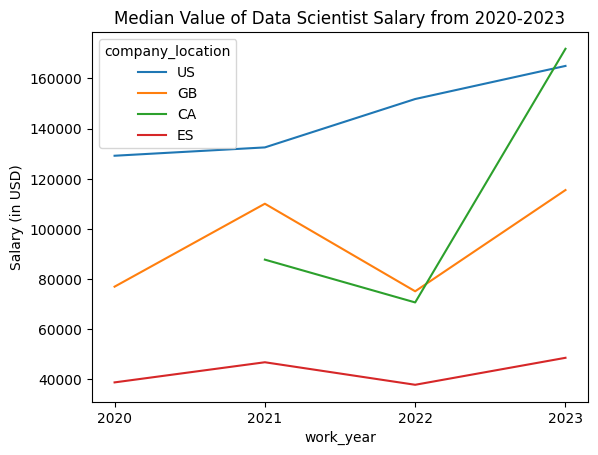

In [38]:
# Per location, using median
sns.lineplot(data=grouped6[grouped6['job_title_group']=='Data Scientist'], x="work_year", y="salary_in_usd", hue='company_location', hue_order = ['US', 'GB', 'CA', 'ES']).set(ylabel='Salary (in USD)')
plt.xticks(ticks=range(2020, 2024))
plt.title('Median Value of Data Scientist Salary from 2020-2023')
plt.show()

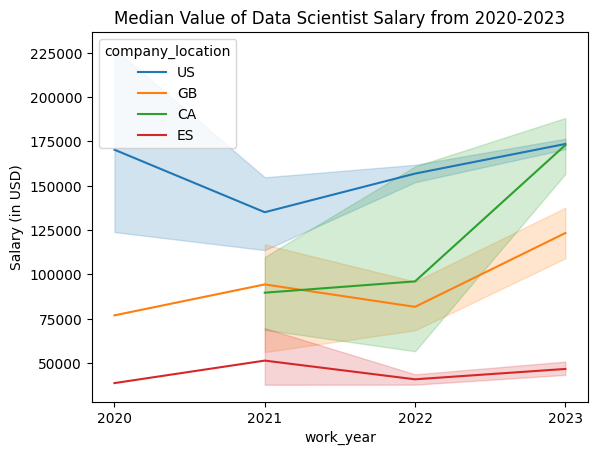

In [39]:
# using mean, with 95% confidence interval
sns.lineplot(data=df4[df4['job_title_group']=='Data Scientist'], x="work_year", y="salary_in_usd", hue='company_location', hue_order = ['US', 'GB', 'CA', 'ES']).set(ylabel='Salary (in USD)')
plt.xticks(ticks=range(2020, 2024))
plt.title('Median Value of Data Scientist Salary from 2020-2023')
plt.show()

In [40]:
# check data for Data Scientist on Great Britain, year 2020
df4[(df4['job_title_group']=='Data Scientist') & (df4['company_location']=='GB') & (df4['work_year']==2020)]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat,job_title_group
8640,2020,MI,FT,Data Scientist,60000,GBP,76958,GB,100,GB,S,remote,Data Scientist


In [41]:
# check data for Data Scientist on Spain, year 2020
df4[(df4['job_title_group']=='Data Scientist') & (df4['company_location']=='ES') & (df4['work_year']==2020)]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat,job_title_group
8778,2020,MI,FT,Data Scientist,34000,EUR,38776,ES,100,ES,M,remote,Data Scientist


There is only one entry each on Data Scientist role for Great Britain and Spain on year 2020, which means analysis on both countries might be not conclusive on said year. However, in all graphs and on all countries, the overall salary increases and reaches its highest average/median over 4 years at 2023.

## Data Scientist vs Data Analyst

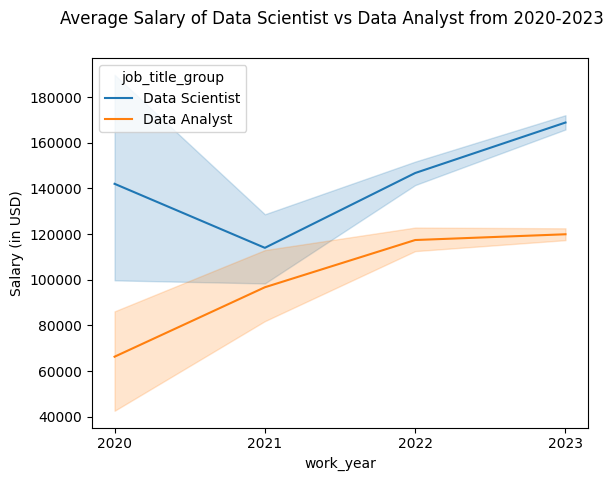

In [42]:
# Overall, using mean with 95% confidence interval
df_ds_da = df4[(df4['job_title_group']=='Data Scientist') | (df4['job_title_group']=='Data Analyst')]
sns.lineplot(data=df_ds_da, x="work_year", y="salary_in_usd", hue='job_title_group').set(ylabel='Salary (in USD)')
plt.xticks(ticks=range(2020, 2024))
plt.suptitle('Average Salary of Data Scientist vs Data Analyst from 2020-2023')
plt.show()

In [43]:
df_ds_da.loc[:,['job_title_group', 'salary_in_usd', 'company_location', 'work_year']] \
    .groupby(['job_title_group', 'work_year']) \
    .mean() \
    .reset_index()

,job_title_group,work_year,salary_in_usd
0,Data Analyst,2020,66316.500000
1,Data Analyst,2021,96729.160000
2,Data Analyst,2022,117411.147147
3,Data Analyst,2023,119932.312399
4,Data Scientist,2020,142028.000000
5,Data Scientist,2021,113991.978723
6,Data Scientist,2022,146758.023474
7,Data Scientist,2023,168866.540613


Data Scientists on average have a higher salary compared to Data Analysts, although the wage gap is quite small at year 2021. At 2020, Data Scientists earns around 49% more than Data Analysts, which is almost identical at year 2023. Both jobs also have a similar salary increase of 36% between 2020 to 2023.